In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
%cd ..
%ls

/home/mahdigilany/offline_codes/codes/ts_snr
configs/     logs/    notebooks/  README.md         scripts/     src/
darts_logs/  main.py  OLD/        requirements.txt  slurm_logs/  wandb/


In [2]:
i_th_run = -3
exp_name = f"nbeats_etth1_test"
main_dir = f"logs/experiments/runs/{exp_name}"
main_dir = os.path.join(os.getcwd(), main_dir)
work_dir = glob(os.path.join(main_dir, "**/darts_logs"), recursive=True)
config_dir = glob(os.path.join(main_dir, "**/config.yaml"), recursive=True)
config_dir = [dir for dir in config_dir if "wandb" not in dir]
work_dir = work_dir[i_th_run]
config_dir = config_dir[i_th_run]
config_dir

'/home/mahdigilany/offline_codes/codes/ts_snr/logs/experiments/runs/nbeats_etth1_test/2023-06-08_13-20-44/config.yaml'

In [3]:
from omegaconf import OmegaConf
from src.driver.drivers import inference_darts_lightning_driver_run

config = OmegaConf.load(config_dir)
config.logger = None
model, data, metrics = inference_darts_lightning_driver_run(config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

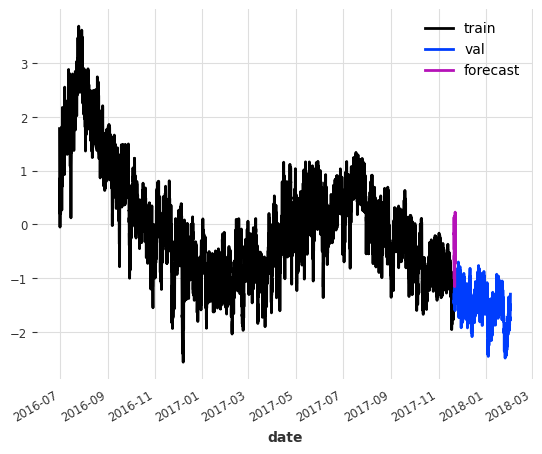

In [4]:
train, val, test, scaler = data.train_series, data.val_series, data.test_series, data.scaler
model.load_weights_from_checkpoint(config.model.model_name, work_dir=work_dir) # don't use load_from_checkpoint since needs logger and produces error
pred = model.predict(series=train, n=36)
# pred_on_val = model.predict(series=val[:24], n=12) # we need such a thing for evaluating the results

train['OT'].plot(label="train")
val['OT'].plot(label="val")
pred['OT'].plot(label="forecast")
# pred_on_val.plot(label="forecast on val")


In [5]:
test_ds = model._build_train_dataset(test, past_covariates=None, future_covariates=None, max_samples_per_ts=None)
from torch.utils.data import DataLoader
from tqdm import tqdm
test_dl = DataLoader(
    test_ds,
    batch_size=model.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    collate_fn=model._batch_collate_fn,
    )

pl_model = model.model 
pl_model.eval()
preds = []
for batch in tqdm(test_dl, desc="evaluating on test set"):
    input_series, _, _, target_series = batch
    input_series = input_series.to(device=pl_model.device, dtype=pl_model.dtype)
    target_series = target_series.to(device=pl_model.device, dtype=pl_model.dtype)
    pred = pl_model((input_series, _))
    preds.append(pred)
preds = torch.cat(preds, dim=0)
# pl_model
# model.trainer.__dict__
# model.trainer.validate(dataloaders=test_dl, model=model.model, ckpt_path=None)
# trainer.test
# model._setup_trainer(trainer, model, verbose, train_num_epochs) # if fit is called, we already have this
# model.eval()

evaluating on test set: 100%|██████████| 85/85 [00:04<00:00, 17.11it/s]


In [15]:
horizon = 96
lookback = 672
i=0
list_backtest_series = []
for i in range(preds.shape[0]):
    preds[i,...]
    test.time_index[lookback+i:lookback+i+horizon].shape
    backtest_series = TimeSeries.from_times_and_values(test.time_index[lookback+i:lookback+i+horizon], preds[i,...].detach().cpu().numpy(), freq=test.freq)
    list_backtest_series.append(backtest_series)

In [18]:
list_backtest_series[0]

(96, 7, 1)

## historical forecast

In [ ]:
from darts.timeseries import concatenate
series = concatenate([train, val])
series.plot(label="series")
backtest_series = model.historical_forecasts(series=series, start=val.start_time(), forecast_horizon=12, retrain=False, verbose=True)


MAPE: 8.33%


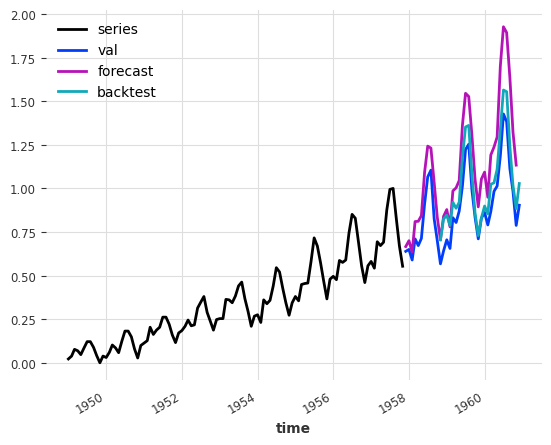

In [6]:
from darts.metrics import mape
train.plot(label="series")
val.plot(label="val")
pred.plot(label="forecast")
backtest_series.plot(label="backtest")
print("MAPE: {:.2f}%".format(mape(scaler[0].inverse_transform(val),scaler[0].inverse_transform(backtest_series))))

tensor(0.0833, dtype=torch.float64)

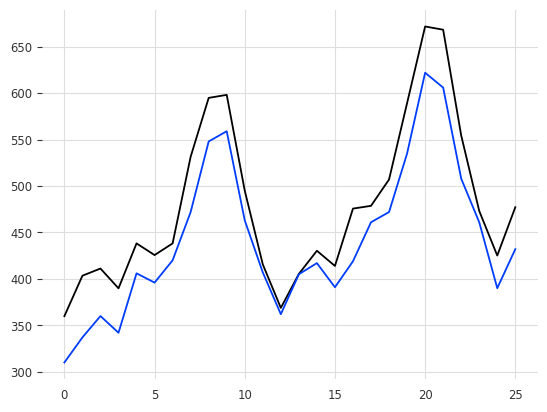

In [7]:

from torchmetrics.functional import mean_absolute_percentage_error
unscaled_val = scaler[0].inverse_transform(val)
unscaled_backtest_series = scaler[0].inverse_transform(backtest_series)
unscaled_backtest_tensor = torch.tensor(unscaled_backtest_series._xa.values)
unscaled_val_tensor = torch.tensor(unscaled_val._xa.values[11:])
plt.plot(unscaled_backtest_tensor.reshape(-1), label="backtest")
plt.plot(unscaled_val_tensor.reshape(-1), label="val")
mean_absolute_percentage_error(unscaled_backtest_tensor, unscaled_val_tensor)

In [9]:
len(val)

37